In [1]:
import os
os.environ['KAGGLE_USERNAME'] = 'jaen11487'
os.environ['KAGGLE_KEY'] = '1e7109f613a54cba533ab49ab46927ff'
!kaggle competitions download -c dogs-vs-cats

100% 271M/271M [00:02<00:00, 144MB/s]
100% 271M/271M [00:02<00:00, 111MB/s]
  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 87.6MB/s]
 98% 532M/543M [00:05<00:00, 135MB/s]
100% 543M/543M [00:05<00:00, 103MB/s]


###### Unzip,  Directory 구성


In [2]:
import zipfile
import os
dir_path = 'cat_dog'

In [3]:
if not os.path.exists(dir_path):
    os.makedirs(dir_path)

with zipfile.ZipFile("train.zip" , "r") as zip_ref:
    zip_ref.extractall(dir_path)

#####  이미지 데이타 디렉토리 생성

In [4]:
sub_dirs = ['train', 'test']
label_dirs = ['cat', 'dog']
for sub_dir in sub_dirs:
    for label_dir in label_dirs:
        os.makedirs(os.path.join(dir_path, sub_dir, label_dir), exist_ok=True)

###### 준비된 디렉토리에 파일 복사
* test 디렉토리에 25% 할당

In [5]:
import glob
import random
import shutil

files = glob.glob(dir_path + '/train/*.jpg')
split_ratio = 0.25

for file in files:
    filename = os.path.basename(file)
    print('file copying...', file, end='\r')
    dst_dir = 'train'
    if random.random() < split_ratio :
        dst_dir = 'test'
    if filename.startswith('cat'):
        dst = os.path.join(dir_path, dst_dir, 'cat', filename)
    else :
        dst = os.path.join(dir_path, dst_dir, 'dog', filename)
    shutil.copyfile(file, dst)
print('copy done.')

copy done.


###### ImageGenerator 준비
* batch 미리 보기

Found 18814 images belonging to 2 classes.
Found 6186 images belonging to 2 classes.


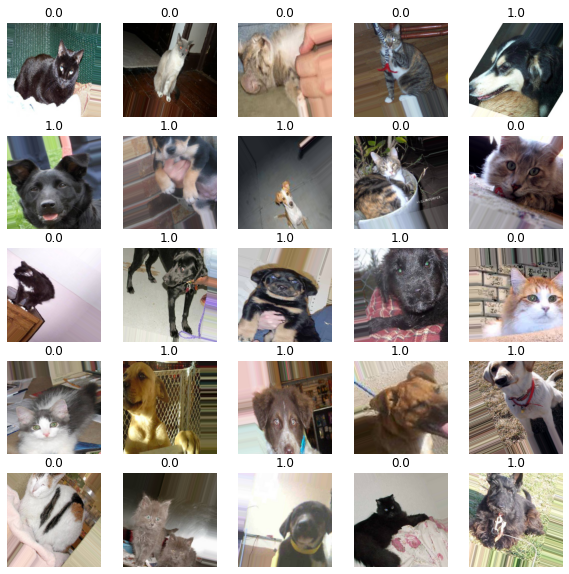

In [6]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os

IMG_SIZE = 224
train_img_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0,
                                                     shear_range=0.2,
                                                     rotation_range=40,
                                                     zoom_range=0.2,
                                                     width_shift_range=0.2,
                                                     height_shift_range=0.2,
                                                     horizontal_flip=True,
                                                     vertical_flip=False)
test_img_gen =  tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0)

train_iter = train_img_gen.flow_from_directory(os.path.join(dir_path, 'train'),\
                                               batch_size=64, target_size=(IMG_SIZE, IMG_SIZE), class_mode='sparse')
test_iter = test_img_gen.flow_from_directory(os.path.join(dir_path, 'test'), \
                                             batch_size=64, target_size=(IMG_SIZE, IMG_SIZE), class_mode='sparse')


image_batch, label_batch = next(train_iter)

plt.figure(figsize=(10,10))
for n in range(25):
    plt.subplot(5,5,n+1)
    plt.imshow(image_batch[n])
    plt.title(label_batch[n])
    plt.axis('off')


In [7]:
import keras
keras.__version__

Using TensorFlow backend.


'2.3.1'

# 사전 훈련된 컨브넷 사용하기

## 특성 추출

![swapping FC classifiers](https://s3.amazonaws.com/book.keras.io/img/ch5/swapping_fc_classifier.png)

### 방법1) 특성추출 후 FC만 학습


VGG16 모델은 케라스에 패키지로 포함되어 있습니다. `keras.applications` 모듈에서 임포트할 수 있습니다. `keras.applications` 모듈에서 사용 가능한 이미지 분류 모델은 다음과 같습니다(모두 ImageNet 데이터셋에서 훈련):

* Xception
* InceptionV3
* ResNet50
* VGG16
* VGG19
* MobileNet

VGG16 모델

In [8]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

58892288/58889256 [==============================] - 1s 0us/step


VGG16 함수에 세 개의 매개변수:

* `weights`는 모델을 초기화할 가중치 체크포인트를 지정
* `include_top`은 네트워크의 최상위 완전 연결 분류기를 포함할지 안할지를 지정합니다. 기본값은 ImageNet의 1,000개의 클래스에 대응되는 완전 연결 분류기를 포함합니다. 별도의 (강아지와 고양이 두 개의 클래스를 구분하는) 완전 연결 층을 추가하려고 하므로 이를 포함시키지 않습니다.
* `input_shape`은 네트워크에 주입할 이미지 텐서의 크기입니다. 이 매개변수는 선택사항입니다. 이 값을 지정하지 않으면 네트워크가 어떤 크기의 입력도 처리할 수 있습니다.

In [9]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     


### 방법
-Freezing Conv + FC + Data Augmentation

In [10]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [11]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


여기서 볼 수 있듯이 VGG16의 합성곱 기반층은 14,714,688개의 매우 많은 파라미터를 가지고 있습니다. 합성곱 기반층 위에 추가한 분류기는 2백만 개의 파라미터를 가집니다.

모델을 컴파일하고 훈련하기 전에 합성곱 기반층을 동결하는 것이 아주 중요합니다. 하나 이상의 층을 동결한다는 것은 훈련하는 동안 가중치가 업데이트되지 않도록 막는다는 뜻입니다. 이렇게 하지 않으면 합성곱 기반층에 의해 사전에 학습된 표현이 훈련하는 동안 수정될 것입니다. 맨 위의 `Dense` 층은 랜덤하게 초기화되었기 때문에 매우 큰 가중치 업데이트 값이 네트워크에 전파될 것입니다. 이는 사전에 학습된 표현을 크게 훼손하게 됩니다.

케라스에서는 `trainable` 속성을 `False`로 설정하여 네트워크를 동결할 수 있습니다:

In [12]:
print('conv_base를 동결하기 전 훈련되는 가중치의 수:', 
      len(model.trainable_weights))

conv_base를 동결하기 전 훈련되는 가중치의 수: 30


In [13]:
conv_base.trainable = False

In [14]:
print('conv_base를 동결한 후 훈련되는 가중치의 수:', 
      len(model.trainable_weights))

conv_base를 동결한 후 훈련되는 가중치의 수: 4


데이터 증식을 사용하여 모델학습

In [16]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.1,
      zoom_range=0.1,
      horizontal_flip=True,
      fill_mode='nearest')

# 검증 데이터는 증식되어서는 안됨
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # 타깃 디렉터리
        os.path.join(dir_path, 'train'),
        # 모든 이미지의 크기를 150 × 150로 변경
        target_size=(150, 150),
        batch_size=20,
        # binary_crossentropy 손실을 사용하므로 이진 레이블이 필요
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        os.path.join(dir_path, 'test'),
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Found 18814 images belonging to 2 classes.
Found 6186 images belonging to 2 classes.
Epoch 1/30
 - 33s - loss: 0.5625 - acc: 0.7305 - val_loss: 0.4172 - val_acc: 0.8270
Epoch 2/30
 - 25s - loss: 0.4259 - acc: 0.8190 - val_loss: 0.4160 - val_acc: 0.8530
Epoch 3/30
 - 25s - loss: 0.3739 - acc: 0.8430 - val_loss: 0.2533 - val_acc: 0.8530
Epoch 4/30
 - 25s - loss: 0.3449 - acc: 0.8475 - val_loss: 0.1822 - val_acc: 0.8750
Epoch 5/30
 - 25s - loss: 0.3353 - acc: 0.8455 - val_loss: 0.2645 - val_acc: 0.8750
Epoch 6/30
 - 25s - loss: 0.3210 - acc: 0.8655 - val_loss: 0.3155 - val_acc: 0.8630
Epoch 7/30
 - 26s - loss: 0.3179 - acc: 0.8636 - val_loss: 0.1836 - val_acc: 0.8925
Epoch 8/30
 - 25s - loss: 0.3060 - acc: 0.8635 - val_loss: 0.2656 - val_acc: 0.8980
Epoch 9/30
 - 25s - loss: 0.3049 - acc: 0.8640 - val_loss: 0.3767 - val_acc: 0.8840
Epoch 10/30
 - 25s - loss: 0.2976 - acc: 0.8685 - val_loss: 0.3371 - val_acc: 0.8940
Epoch 11/30
 - 25s - loss: 0.2758 - acc: 0.8810 - val_loss: 0.4267 - val_a

In [18]:
model.save('cats_and_dogs_small_3.h5')


# Accuracy & Loss

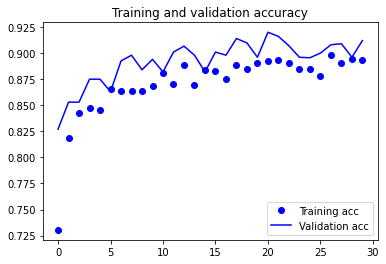

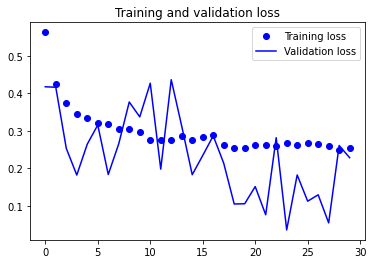

In [19]:
import matplotlib.pyplot as plt 

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()